In [1]:
# from labdaq.utils import *
# default_preferences


In [5]:
1/(2*0.1)


5.0

In [1]:

import nidaqmx
%matplotlib notebook
import pylab as plt
import numpy as np

import time
class Task():
    def __init__(self, aichan = 'Dev2/ai0', 
                 aochan='Dev2/ao0',
                 modechan='Dev2/ai1',
                 aiconversion=[1000,100],
                 aoconversion = [0.05,0.00005],
                 srate = 20000):
        # init tasks
        self.task_ai = None
        self.task_ao = None
        self.task_di = None
        self.task_do = None
        self.srate = srate
        self.aoconversion = np.float32(aoconversion)
        self.aiconversion = np.float32(aiconversion)
        if not aichan is None:
            self.task_ai = nidaqmx.Task()
            self.task_ai.ai_channels.add_ai_voltage_chan(aichan)
            #elf.task_ai.triggers.sync_type.MASTER = True
            #elf.task_ai.control(nidaqmx.constants.TaskMode.TASK_COMMIT)
        if not aochan is None:
            self.task_ao = nidaqmx.Task()
            #f not self.task_ai is None:
            #   self.task_ao.triggers.sync_type.SLAVE = True
            self.task_ao.ao_channels.add_ao_voltage_chan(aochan)
        if not modechan is None:
            self.task_mode = nidaqmx.Task()
            self.task_mode.ai_channels.add_ai_voltage_chan(modechan)
        self.mode = None
        self._check_mode()
    def load(self,stim):
        self._check_mode()
        if self.mode in ['IC','IC=0']:
            aoconversion = self.aoconversion[1]
            print('in cclamp')
        else:
            aoconversion = self.aoconversion[0]
        self.nsamples = max(stim.shape)
        if not self.task_ai is None:
            self.task_ai.timing.cfg_samp_clk_timing(rate = self.srate,
                                                    samps_per_chan = self.nsamples)
        if not self.task_ao is None:
            self.task_ao.timing.cfg_samp_clk_timing(rate = self.srate,
                                                    samps_per_chan = self.nsamples)
            self.task_ao.write((stim*aoconversion).astype(np.float32), auto_start=False)
    
    def _check_mode(self):
        if not hasattr(self,'task_mode'):
            return None
        mm = int(np.round(self.task_mode.read()))
        if mm in [2,1,4]:
            self.mode = 'IC'
        elif mm == 3:
            self.mode = 'IC=0'
        elif mm in [4,5]:
            self.mode = 'VC'
        else:
            self.mode = None
    def run(self):
        self._check_mode()
        if self.mode in ['IC','IC=0']:
            aiconversion = self.aiconversion[1]
        else:
            aiconversion = self.aiconversion[0]
        self.task_ai.start()
        self.task_ao.start()
        data=self.task_ai.read(number_of_samples_per_channel = nidaqmx.constants. READ_ALL_AVAILABLE)
        self.task_ai.stop()
        self.task_ao.stop()
        return np.array(data)*aiconversion
    
    def close(self):
        self.task_ai.close()
        self.task_ao.close()
task = Task()

# with  as task:
#     task.ao_channels.add_ao_voltage_chan('Dev2/ao0')
#     task.timing.cfg_samp_clk_timing(srate)
#     print('1 Channel N Samples Write: ')
#     print(task.write(pulse.astype(np.float32), auto_start=True))
#     time.sleep(1)
#     task.stop()
    

<IPython.core.display.Javascript object>


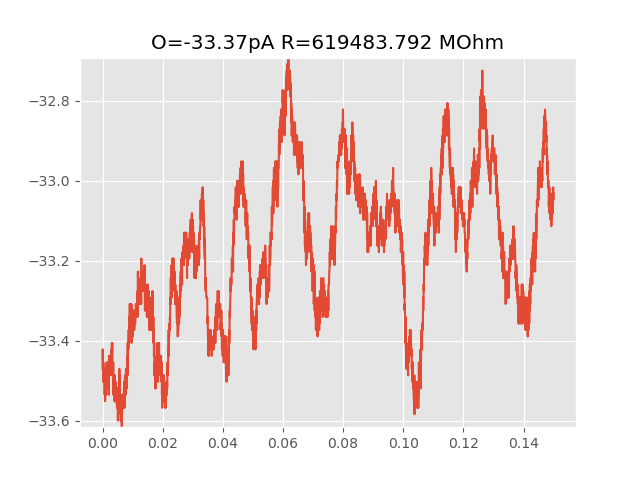

In [4]:
from ipywidgets import (interact, interactive, fixed, interact_manual)
from ipywidgets import (Select, Textarea, Button,Dropdown, VBox,
                        HBox, Layout, Label, Text,Play,jslink)
from IPython.display import display
from ipywidgets import Play,jslink,HBox

from matplotlib.animation import FuncAnimation
plt.matplotlib.style.use('ggplot')
def nbSealTest(task,interval=500,amp=[10,200],**kwargs):
    srate = task.srate    
    if task.mode == 'VC':
        amplitude = amp[0]
    else:
        amplitude = amp[1]
    pulse = np.hstack([np.zeros(int(0.05*srate)),amplitude*np.ones(int(0.05*srate)),np.zeros(int(0.05*srate))])    
    time = np.arange(len(pulse))/srate
    fig = plt.gcf()
    im = plt.plot(time,pulse,**kwargs)[0]
    
    def animate(change):
        if task.mode == 'VC':
            amplitude = amp[0]
        else:
            amplitude = amp[1]
        pulse = np.hstack([np.zeros(int(0.05*srate)),amplitude*np.ones(int(0.05*srate)),np.zeros(int(0.05*srate))])    

        task.load(pulse)
        data = task.run()
        dd = np.array(data)
        im.set_ydata(dd)
        Ipre = np.mean(dd[(time<0.03)])
        Istim = np.mean(dd[(time>0.06
                           
                           ) & (time<0.09)])
        # This needs an IF because of thje units
        R = (amplitude*1e-3/((Istim-Ipre)*1e-12))/1e6
        
        plt.title('O={0:.2f}pA R={1:.3f} MOhm'.format(Ipre,R))
        plt.ylim([np.min(dd),np.max(dd)])
    anim = FuncAnimation(fig, animate, interval=interval)
    return dict(fig = plt.gcf(),ax=plt.gca(),im= im,anim = anim)
plt.figure()
anim = nbSealTest(task)


In [5]:
task._check_mode()
print(task.mode)

IC


In [ ]:
plt.figure()

task.load(np.zeros(20000*10))
values= task.run()
plt.plot(values)

<IPython.core.display.Javascript object>


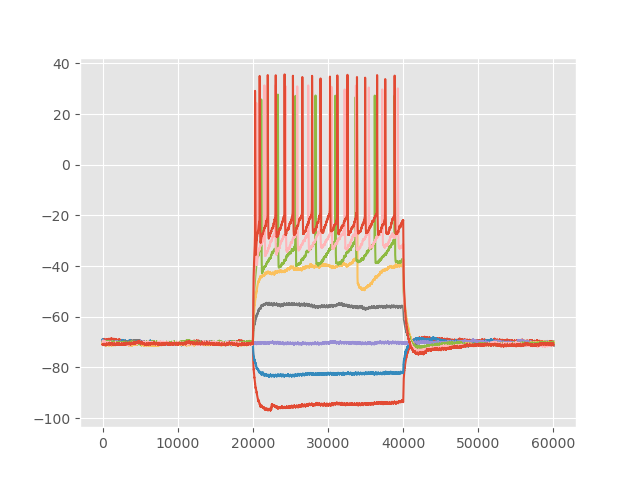

in cclamp
in cclamp
in cclamp
in cclamp
in cclamp
in cclamp
in cclamp
in cclamp


In [4]:
plt.matplotlib.style.use('ggplot')

plt.figure()
for amplitude in range(-100,300,50):
    srate = task.srate
    pulse = np.hstack([np.zeros(int(1*srate)),amplitude*np.ones(int(1*srate)),np.zeros(int(1*srate))])    
    time = np.arange(len(pulse))/srate
    task.load(pulse)
    values= task.run()
    plt.plot(values)

In [5]:
plt.savefig('C:/Users/tony/Desktop/myfirstcell_01.pdf')

